# Exploring SFPD Police Incident Report Data
The dataset available has SFPD police incident report data from January 2003 to May 2018. The goal is to perform analysis on the available data to discern trends over the years in San Francisco's crime scene.

The data is freely available at [datasf.org](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).


In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as prepro
from folium.plugins import HeatMap

In [2]:
# read data from csv file
data = pd.read_csv("./data/SFPD-Incident-Reports-Jan2003-May2018.csv")

#preview rows,cols
#print(data.shape)
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129525 entries, 0 to 2129524
Data columns (total 35 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   PdId                                                      int64  
 1   IncidntNum                                                int64  
 2   Incident Code                                             int64  
 3   Category                                                  object 
 4   Descript                                                  object 
 5   DayOfWeek                                                 object 
 6   Date                                                      object 
 7   Time                                                      object 
 8   PdDistrict                                                object 
 9   Resolution                                                object 
 10  Address                       

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,3114751606302,31147516,6302,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000,POINT (-120.50000000000001 90),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5069701104134,50697011,4134,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896,POINT (-122.42822330317601 37.7818959488603),97.0,4.0,11.0,39.0,7.0,9.0,11.0,29490.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,97.0
2,6074729204104,60747292,4104,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789,POINT (-122.41067242533701 37.799788690123),106.0,6.0,3.0,6.0,3.0,1.0,10.0,308.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,106.0
3,7103536315201,71035363,15201,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362,POINT (-122.458226300605 37.7413616001449),49.0,10.0,8.0,41.0,1.0,8.0,4.0,59.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,49.0
4,11082415274000,110824152,74000,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200,POINT (-122.459172646607 37.7082001648459),NaN,NaN,NaN,NaN,NaN,NaN,NaN,28588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 35 columns but we definitely don't need them all. It also looks like there may be null values throughout the dataset. Of particular interest is the Date and Time columns which we can use for temporal analysis. We also need to check for nulls and duplicates and drop them from our dataset.

In [3]:
# lets read the csv data again but this time parse the date and time columns as datetime
data = pd.read_csv("./data/SFPD-Incident-Reports-Jan2003-May2018.csv", parse_dates=[['Date','Time']])

#we don't need all 35 columns, so lets select what we determine to be relevant
data = data[["Date_Time","Category","Descript",'DayOfWeek',"PdDistrict","Resolution","Address","X","Y"]]

#preview rows,cols
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129525 entries, 0 to 2129524
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date_Time   datetime64[ns]
 1   Category    object        
 2   Descript    object        
 3   DayOfWeek   object        
 4   PdDistrict  object        
 5   Resolution  object        
 6   Address     object        
 7   X           float64       
 8   Y           float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 146.2+ MB


,Date_Time,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-09-28 10:00:00,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000
1,2005-06-22 12:20:00,ASSAULT,BATTERY,Wednesday,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896
2,2006-07-15 00:55:00,ASSAULT,ASSAULT,Saturday,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789
3,2007-09-25 00:01:00,ASSAULT,STALKING,Tuesday,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362
4,2011-09-24 11:00:00,MISSING PERSON,MISSING ADULT,Saturday,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200


In [4]:
#check for nulls
data.isnull().sum()

Date_Time     0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [5]:
#drop nulls
data.dropna(inplace=True)

data.isnull().sum()

Date_Time     0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
#check how many duplicate entries there are
data.duplicated().sum()

5520

In [7]:
#drop duplicate entries
data.drop_duplicates(subset=None, keep="first", inplace=True)

#preview rows,cols
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124004 entries, 0 to 2129524
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date_Time   datetime64[ns]
 1   Category    object        
 2   Descript    object        
 3   DayOfWeek   object        
 4   PdDistrict  object        
 5   Resolution  object        
 6   Address     object        
 7   X           float64       
 8   Y           float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 162.0+ MB


,Date_Time,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-09-28 10:00:00,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000
1,2005-06-22 12:20:00,ASSAULT,BATTERY,Wednesday,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896
2,2006-07-15 00:55:00,ASSAULT,ASSAULT,Saturday,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789
3,2007-09-25 00:01:00,ASSAULT,STALKING,Tuesday,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362
4,2011-09-24 11:00:00,MISSING PERSON,MISSING ADULT,Saturday,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200


We can infer from the number of rows that there are 2,129,525 number of crimes in the dataset. Of which around 5,520 were duplicates and one had a null value leaving a total of 2,124,004 crimes.

We also have temporal data in the dataset that we can format better.

We can breakdown the Date_Time column to split data by year, month and day. Note that we only have 2018 data from Jan to May so we are going to drop 2018.

In [8]:
data['Year'] = pd.DatetimeIndex(data['Date_Time']).year
data['Month'] = pd.DatetimeIndex(data['Date_Time']).month
data['Day'] = pd.DatetimeIndex(data['Date_Time']).day

In [9]:
data = data[data['Year'] != 2018]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2079049 entries, 0 to 2129524
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date_Time   datetime64[ns]
 1   Category    object        
 2   Descript    object        
 3   DayOfWeek   object        
 4   PdDistrict  object        
 5   Resolution  object        
 6   Address     object        
 7   X           float64       
 8   Y           float64       
 9   Year        int64         
 10  Month       int64         
 11  Day         int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 206.2+ MB


After dropping the 2018 year data, we are left with 2,079,049 incident reports.

We've cleaned up this data enough to finally start some exploratory data analysis.

We can visualise the data with a correlation heatmap for all our features in the dataset but we would have to first encode our categorical features (PdDistrict, Category, Address,etc.)

In [10]:
# make a copy of the data
data_enc = data.copy()

# label encoding
for i in ['Category','Descript','DayOfWeek','PdDistrict','Resolution','Address']:
    data_enc[i] = prepro.LabelEncoder().fit_transform(data_enc[i])

In [11]:
#correlation matrix
corr_mat = data_enc.corr()
corr_mat

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day
Category,1.000000,0.440662,0.001038,-0.043643,0.010424,0.032568,-0.020959,-0.001954,-0.016573,-0.000090,0.000295
Descript,0.440662,1.000000,0.011442,0.008413,-0.206074,0.046346,0.009814,-0.000248,-0.085207,-0.004147,-0.000616
DayOfWeek,0.001038,0.011442,1.000000,0.009030,-0.027749,-0.000394,-0.000478,-0.000776,-0.009656,-0.001191,-0.001610
PdDistrict,-0.043643,0.008413,0.009030,1.000000,-0.071701,-0.015169,-0.269367,0.017083,-0.007023,-0.001204,-0.002604
Resolution,0.010424,-0.206074,-0.027749,-0.071701,1.000000,-0.075203,-0.080167,-0.002829,0.054076,0.019865,-0.000013
Address,0.032568,0.046346,-0.000394,-0.015169,-0.075203,1.000000,0.027746,0.014133,-0.000882,0.006328,0.006139
X,-0.020959,0.009814,-0.000478,-0.269367,-0.080167,0.027746,1.000000,0.536579,-0.012134,0.003219,0.002935
Y,-0.001954,-0.000248,-0.000776,0.017083,-0.002829,0.014133,0.536579,1.000000,-0.009065,0.002297,0.001101
Year,-0.016573,-0.085207,-0.009656,-0.007023,0.054076,-0.000882,-0.012134,-0.009065,1.000000,0.004699,0.005374
Month,-0.000090,-0.004147,-0.001191,-0.001204,0.019865,0.006328,0.003219,0.002297,0.004699,1.000000,0.007494


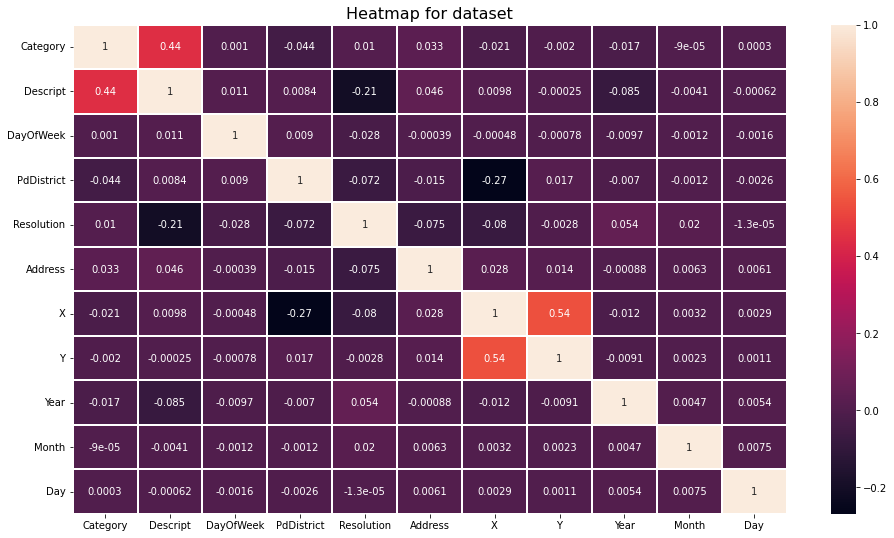

In [12]:
plt.figure(figsize=(16,9))
sns.heatmap(corr_mat, annot=True, linewidths=.1)
plt.title('Heatmap for dataset', fontsize=16)
plt.show()

We can determine the different categories of crimes and number of crimes in each category.

In [13]:
num_crimes_cat = data["Category"].value_counts()
print(num_crimes_cat)

LARCENY/THEFT                  462549
OTHER OFFENSES                 295981
NON-CRIMINAL                   230759
ASSAULT                        163027
VEHICLE THEFT                  124530
DRUG/NARCOTIC                  116211
VANDALISM                      111625
WARRANTS                        98100
BURGLARY                        88657
SUSPICIOUS OCC                  77332
ROBBERY                         53384
MISSING PERSON                  42993
FRAUD                           40438
FORGERY/COUNTERFEITING          22751
SECONDARY CODES                 21891
WEAPON LAWS                     20386
TRESPASS                        18656
PROSTITUTION                    16197
STOLEN PROPERTY                 11185
DISORDERLY CONDUCT               9827
DRUNKENNESS                      9670
RECOVERED VEHICLE                8677
SEX OFFENSES, FORCIBLE           8438
DRIVING UNDER THE INFLUENCE      5557
KIDNAPPING                       4227
ARSON                            3775
EMBEZZLEMENT

It seems that the most prevalent type of crime from 2003 to 2018 is larceny/theft. We can plot a bar chart to visualise the data here.

<AxesSubplot:title={'center':'Crime occurences by category'}, xlabel='Category', ylabel='Occurences'>

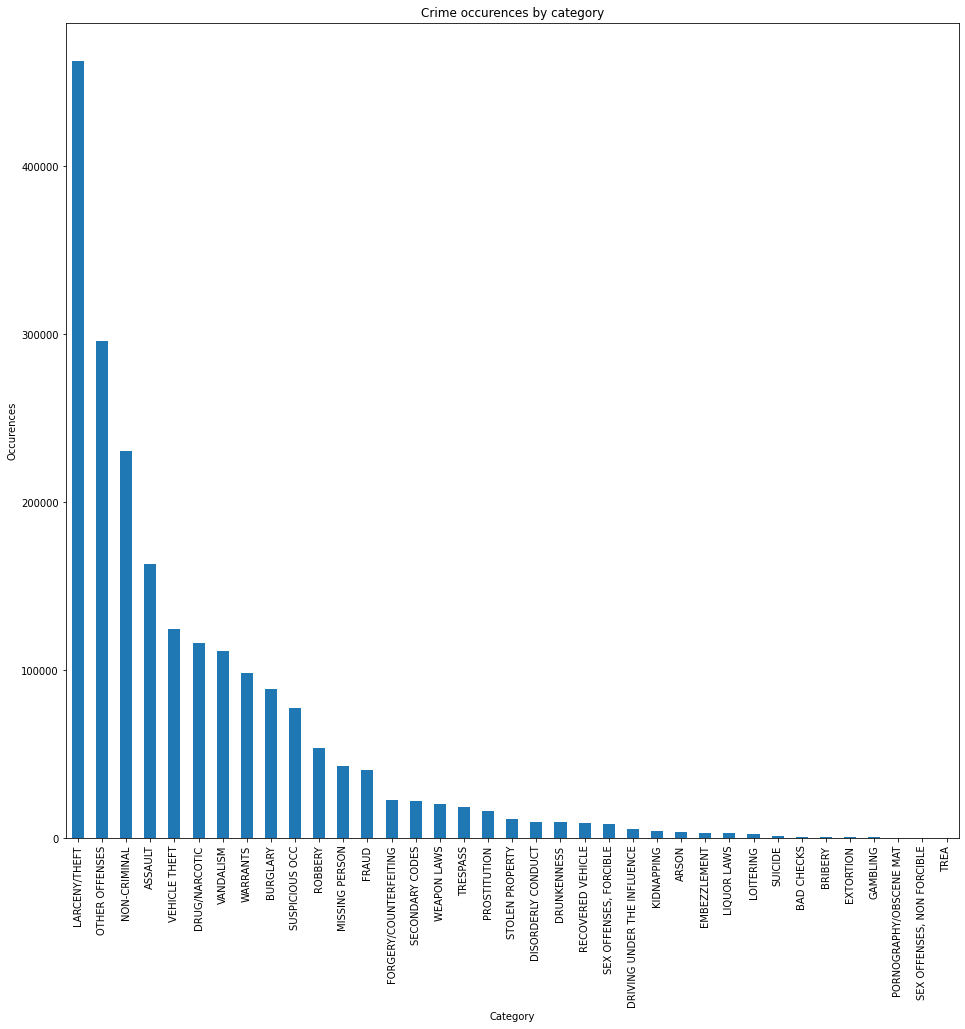

In [14]:
plt.figure()
num_crimes_cat.plot(kind='bar',xlabel='Category',ylabel='Occurences',title='Crime occurences by category',figsize=(16,15))

We can also check which day has the highest number of crimes committed.

<AxesSubplot:title={'center':'Crime occurences by day of the week'}, xlabel='Day', ylabel='Occurences'>

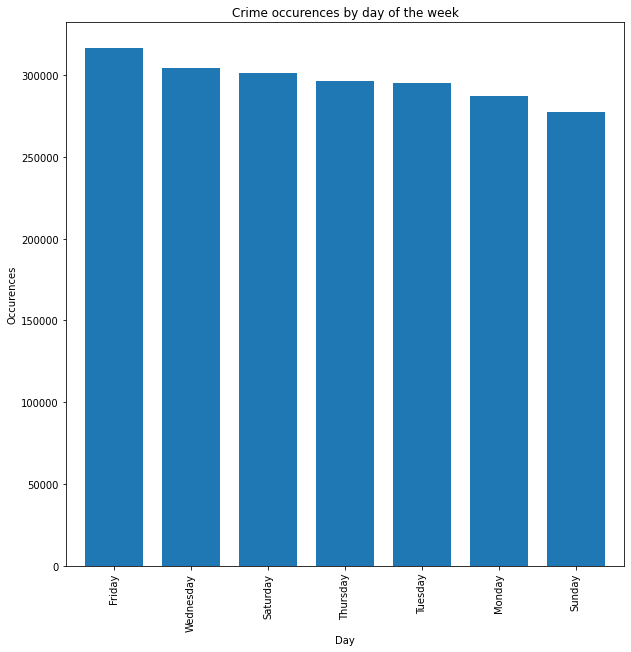

In [15]:
crime_days = data["DayOfWeek"].value_counts()
crime_days.plot(kind='bar',xlabel='Day',ylabel='Occurences',title='Crime occurences by day of the week',figsize=(10,10),width=0.75)

We can check the descriptions and see what is the most prevalent as well.

<AxesSubplot:title={'center':'Crime occurences vs Description'}, xlabel='Description', ylabel='Occurences'>

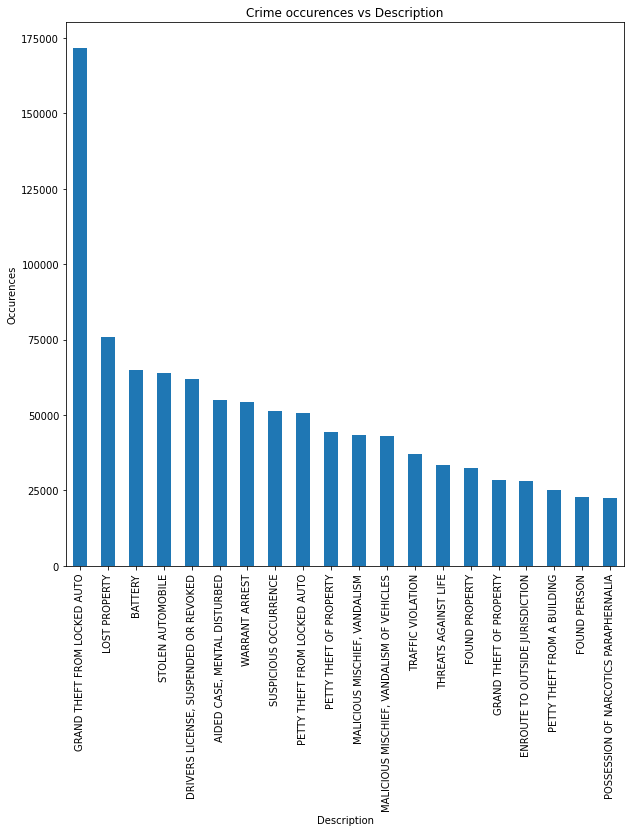

In [16]:
desc = data["Descript"].value_counts()
# limit to top 20 due to volume of descriptions
desc[:20].plot(kind='bar',xlabel='Description',ylabel='Occurences',title='Crime occurences vs Description', figsize=(10,10))

The PdDistricts column can give us an idea of which neighbourhoods we may want to avoid in SF.

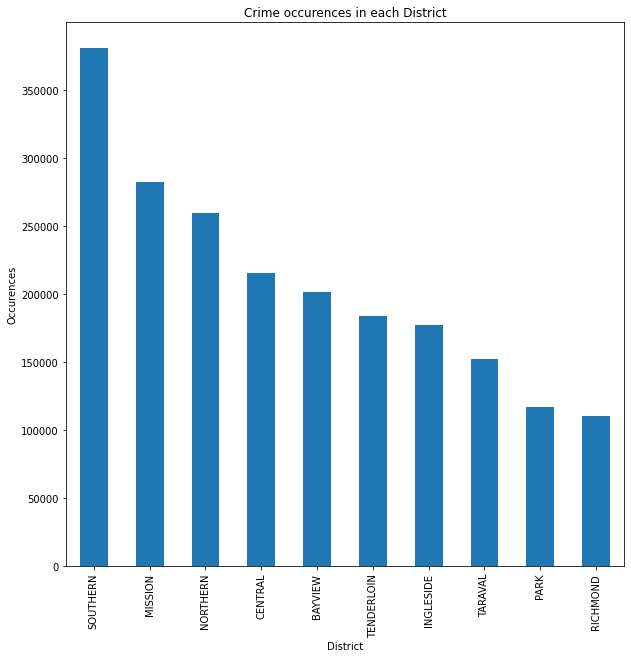

In [17]:
plt.figure()
data['PdDistrict'].value_counts().plot(kind='bar',xlabel='District',ylabel='Occurences',title='Crime occurences in each District', figsize=(10,10))
plt.show()

<AxesSubplot:title={'center':'Crime occurences per year'}, xlabel='Year', ylabel='Occurences'>

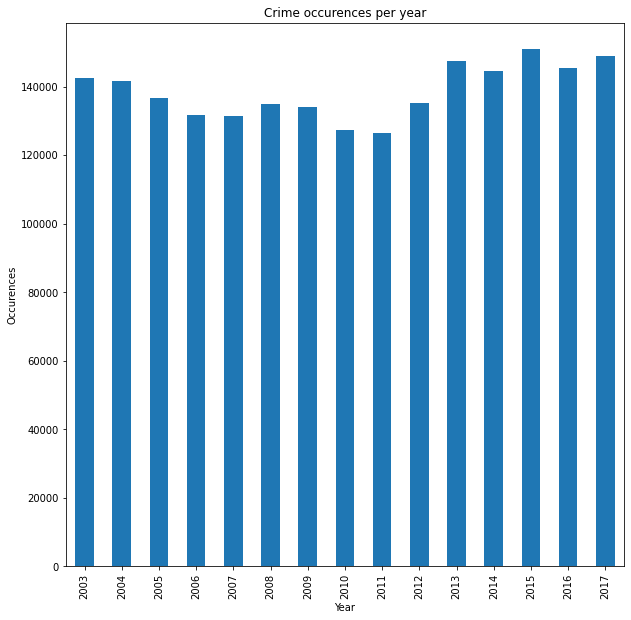

In [18]:
years_data = data['Year'].value_counts().sort_index()
years_data.plot(kind='bar',xlabel='Year',ylabel='Occurences',title='Crime occurences per year', figsize=(10,10))

Suppose we want to find out about a specific category of crime being committed over the years. We can now do so since we processed the year information earlier.

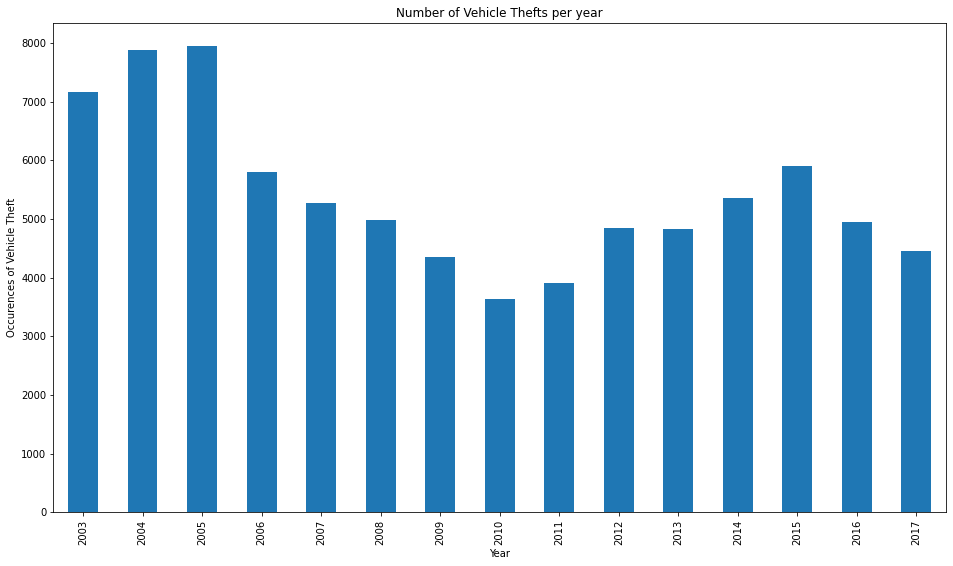

In [19]:
vehicle_theft_df = data[data['Category'] == 'VEHICLE THEFT']
yearly_vehicle_theft = vehicle_theft_df.groupby('Year').Date_Time.nunique()
plt.figure()
yearly_vehicle_theft.plot(kind='bar',xlabel='Year', ylabel='Occurences of Vehicle Theft', title='Number of Vehicle Thefts per year',figsize=(16,9))
plt.show()
# vehicle_theft_df.head()

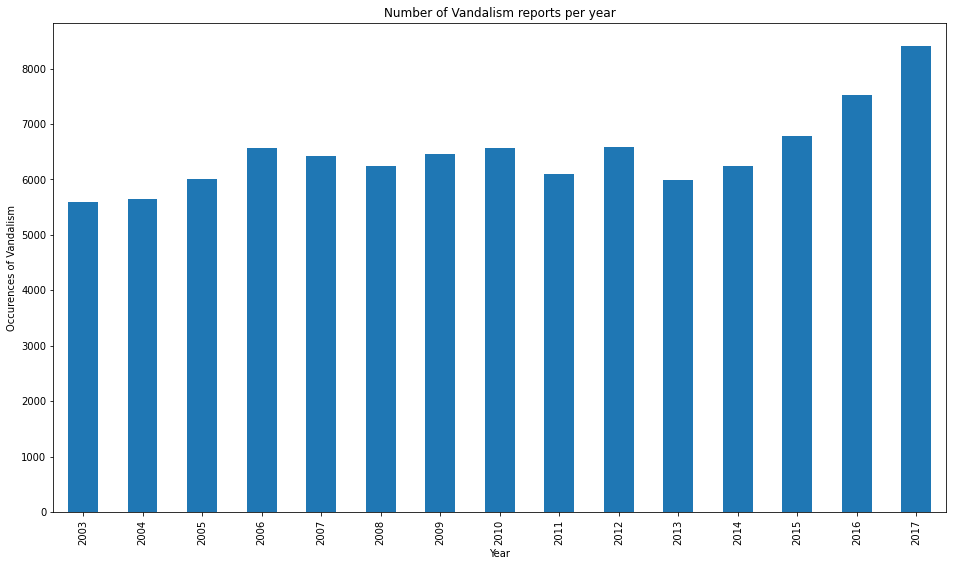

In [20]:
vandalism_df = data[data['Category'] == 'VANDALISM']
yearly_vandalism = vandalism_df.groupby('Year').Date_Time.nunique()
plt.figure()
yearly_vandalism.plot(kind='bar',xlabel='Year', ylabel='Occurences of Vandalism', title='Number of Vandalism reports per year',figsize=(16,9))
plt.show()